# E. coli Promoter Classification with Genomic Ensemble Pretraining

This notebook follows on from the previous. Here we train a promoter classification model in the same way as before. The only thing we change is initializing the classification model with weights from a better language model. The previous language model was trained on just the E. coli genome. It trained to a validation loss of 2.63. The new model is trained on an ensemble of different bacterial genomes, which trained to a validation loss of 2.50. We will see that this has a large impact on performance.

To avoid clutter, confusion, and long notebooks, I separated the training of the new language model to a different notebook. The data preparation for the bacterial ensemble is found in the [Bacterial Ensemble Data Processing](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/Bacterial%20Ensemble/Genomic%20Language%20Models/Bacterial%20Ensemble%20LM%200%20Data%20Processing.ipynb) notebook. Training of the new language model is detailed in the [Bacterial Ensemble Language Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/Bacterial%20Ensemble/Genomic%20Language%20Models/Bacterial%20Ensemble%20LM%201%205-mer%20Language%20Model.ipynb) notebook.

This notebook shows how using a better trained language model as the basis for a classification model has a significant effect on performance - much more so than training longer on classification data. This method really shines when you have a lot of unlabeled genomic data to throw at it.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Callable

# sets device for model and PyTorch tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7" # "-1" if want to run on a CPU, otherwise define the GPU number

In [3]:
from fastai import *
from fastai.text import ( BaseTokenizer, Tokenizer, Vocab, 
                         PreProcessor, ItemList, PathOrStr, 
                         DataFrame, Optional, Collection, 
                         IntsOrStrs, DataBunch, is_listy, 
                         ItemLists, TextList, SortishSampler, 
                         DataLoader, SortSampler, partial, 
                         pad_collate, TextLMDataBunch, data_collate, 
                         LanguageModelPreLoader )
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [4]:
sys.path.append("../..")
from utils import ( _get_genomic_processor, get_model_clas, TextClasDataBunch, 
                    get_scores, split_data, GenomicTokenizer, get_model_LM, 
                   GenomicVocab, GenomicTextClasDataBunch)

In [5]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/')
path_bact = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/')

# Classification

In [6]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [7]:
classification_df.head()

,Gene,Locus,Location,Sample Location,Orientation,Sequence,Promoter,Independent,set
0,['yaaX'],['b0005'],[5233:5530](+),[5133:5283](+),forward,GTAACTTAGAGATTAGGATTGCGGAGAATAACAACCGCCGTTCTCA...,1,False,train
1,['talB'],['b0008'],[8237:9191](+),[8137:8287](+),forward,ATAACCGTCTTGTCGGCGGTTGCGCTGACGTTGCGTCGTGATATCA...,1,False,train
2,['yaaW'],['b0011'],[10642:11356](-),[11306:11456](-),reverse,TCAAAAATCACCTTTTCGGGTCATACGGTGAACTCATCGGATATGG...,1,False,train
3,['hokC'],['b4412'],[16750:16903](-),[16853:17003](-),reverse,AAAGCCCCGAGTGATATTTTACCATCAACCCGAGGCCTCCTATATG...,1,False,train
4,['nhaA'],['b0019'],[17488:18655](+),[17388:17538](+),forward,TAAAAAACGAATTATTCCTACACTATAATCTGATTTTAACGATGAT...,1,False,train


In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

Here we create a dataloader with the vocabulary used for the bacterial ensemble model

In [9]:
voc = np.load(path_bact/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

The classification model is structured exactly the same as in previous notebooks

In [11]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [12]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [13]:
learn.load_encoder('coli_only_LM_enc')

RNNLearner(data=GenomicTextClasDataBunch;

Train: LabelList (6791 items)
x: TextList
GTAAC AACTT CTTAG TAGAG GAGAT GATTA TTAGG AGGAT GATTG TTGCG GCGGA GGAGA AGAAT AATAA TAACA ACAAC AACCG CCGCC GCCGT CGTTC TTCTC CTCAT CATCG TCGAG GAGTA GTAAT AATCT TCTCC TCCGG CGGAT GATAT TATCG TCGAC GACCC CCCAT CATAA TAACG ACGGG GGGCA GCAAT AATGA TGATA ATAAA AAAAG AAGGA GGAGT AGTAA TAACC ACCTG CTGTG GTGAA GAAAA AAAAG AAGAT GATGC TGCAA CAATC ATCTA CTATC ATCGT CGTAC TACTC CTCGC CGCAC CACTT CTTTC TTCCC CCCTG CTGGT GGTTC TTCTG CTGGT GGTCG,ATAAC AACCG CCGTC GTCTT CTTGT TGTCG TCGGC GGCGG CGGTT GTTGC TGCGC CGCTG CTGAC GACGT CGTTG TTGCG GCGTC GTCGT CGTGA TGATA ATATC ATCAT CATCA TCAGG AGGGC GGCAG CAGAC GACCG CCGGT GGTTA TTACA ACATC ATCCC CCCCC CCCTA CTAAC AACAA CAAGC AGCTG CTGTT GTTTA TTAAA AAAGA AGAGA AGAAA AAATA ATACT ACTAT TATCA TCATG ATGAC GACGG CGGAC GACAA CAAAT AATTG TTGAC GACCT CCTCC TCCCT CCTTC TTCGT CGTCA TCAGT AGTAC TACAC CACCA CCACC ACCGT CGTAG TAGTG GTGGC GGCCG,TCAAA AAAAA AAATC ATCAC CACCT CCTTT TTT

In [14]:
learn.load_encoder('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/bacterial_genomes/models/b2_enc')
learn.freeze()

In [15]:
# get info
#?learn
#??learn
#learn?? gets source code
#??np
#import fastai
#fastai.text.learner._model_meta
print('model has vocab of: {}'.format(len(model_vocab.stoi.keys())))
print('= 4**5 (4 diff base pairs, 5 mer) + 1 (pad)')
print('embedding size = {}'.format(clas_config['emb_sz']))

model has vocab of: 1025
= 4**5 (4 diff base pairs, 5 mer) + 1 (pad)
embedding size = 400


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


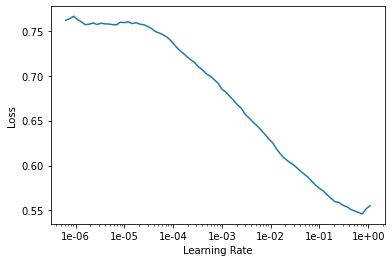

In [16]:
learn.lr_find()
learn.recorder.plot()

Here we follow the same training procedure as before. After 3 epochs on the training data, this model is performing better than the previous. This is entirely due to starting with a better language model.

In [17]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.508745,0.538421,0.786667,00:13
1,0.456752,0.416247,0.825333,00:13
2,0.425982,0.396747,0.825333,00:11


In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.396260,0.499504,0.821333,00:15
1,0.366376,0.342171,0.849333,00:15
2,0.321822,0.275099,0.888000,00:15


In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.277434,0.318104,0.872000,00:24
1,0.279993,0.260006,0.897333,00:24
2,0.236075,0.215157,0.913333,00:24


In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.166351,0.249429,0.894667,00:33
1,0.167716,0.262893,0.893333,00:33
2,0.154514,0.185165,0.929333,00:33
3,0.135568,0.189102,0.928000,00:33
4,0.122304,0.183790,0.930667,00:33


In [21]:
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.101659,0.183431,0.928000,00:33
1,0.103850,0.185071,0.929333,00:33
2,0.099290,0.191420,0.932000,00:32
3,0.095385,0.184863,0.933333,00:33
4,0.093220,0.184833,0.933333,00:33


In [22]:
learn.save('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/models/coli_bact_pretrain')

# Test

In [23]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [24]:
get_scores(learn)

Accuracy: 0.9349397590361446
False Positives: 0.03855421686746988
False Negatives: 0.02650602409638554
Recall: 0.946987951807229
Precision: 0.9247058823529412
Specificity: 0.9228915662650602
MCC: 0.870132169694832


The bacterial ensemble pretrained model easily beats the E. coli genome pretrained model. The E. coli pretrained model trained to a validation loss of 0.24, while the ensemble pretrained model trained to a validation loss of 

Comparing this model to the E. coli pretrained model, accuracy increased from 91.9% to 97.3%, precision increased from 0.94 to 0.98, recall increased from 0.89 to 0.96, and MCC increased from 0.839 to 0.947.

The models were trained on the classification dataset for the same number of epochs. The increased performance shows the impact of a well trained language model on this technique. In addition to improved performance, the ensemble pretrained model overfit less and required less regularization (lower dropout).